### ⚙️ Configuración inicial y funciones auxiliares

En este bloque se importan las librerías necesarias para el análisis y clasificación de datos. También se crean funciones auxiliares para:

- **Guardar imágenes de resultados**.
- **Graficar curvas ROC multicategoría**.
- **Visualizar la matriz de confusión con porcentajes**.
- **Calcular métricas ROC en problemas multiclase**.

Estas herramientas facilitarán la interpretación y presentación de los resultados del modelo.



In [4]:
#librerias a importar
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import roc_curve, auc
from itertools import cycle

import warnings
warnings.filterwarnings("ignore")

#crear carpeta resultados
try:
  os.mkdir('results')
except:
  print("Carpeta results ya existe")

#%%  guardar figuras
def save_fig(path_img,fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(path_img, fig_id + "." + fig_extension)
    print("Guardando...", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    files.download(path)

import seaborn as sns

#curvas roc multiclase
def roc_auc_mc(roc_auc,fpr,tpr,n_classes,title,path_img):
    lw = 2
    # Falsos positivos
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    # roc
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i]) #interpolar para suavizar
    # promediado sobre numero de clases
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # graficar
    plt.figure(figsize=(6,6))
    plt.plot(fpr["micro"], tpr["micro"],
             label='micro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["micro"]),
             color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
             label='macro-average ROC curve (area = {0:0.2f})'
                   ''.format(roc_auc["macro"]),
             color='navy', linestyle=':', linewidth=4)

    #colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    colors = sns.color_palette(None, n_classes)
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                 label='AUC_class_{0} (area = {1:0.2f})'
                 ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="best")#,bbox_to_anchor=(1.4, 0.75))
    plt.show()


#matriz confusión = #[[TN FP][FN TP]]
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') #clasificador aleatorio
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


# ROC curve and ROC
def roc_multiclass(ytrue,yscore):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    n_classes = ytrue.shape[1]
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(ytrue[:, i], yscore[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Calcular micro-average ROC curve y ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(ytrue.ravel(), yscore.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    return roc_auc, fpr, tpr, n_classes

def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    gráfica la matriz de confusión con y sin normalización
    """
    if not title:
        title = 'Matriz de confusión'

    # calcular matriz de confusión
    cm = 100*confusion_matrix(y_true, y_pred,normalize="true")
    # se identifican las etiquetas en los datos
    classes = classes[unique_labels(y_true, y_pred)]

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # mostrar ticks
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='Etiqueta original',
           xlabel='Predicción')

    # Rotar ticks
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # textos.
    fmt = '.1f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

### 🧾 Carga y visualización del conjunto LFW

Se carga el conjunto de datos **Labeled Faces in the Wild (LFW)**, filtrando solo aquellas personas con al menos 70 imágenes. Los datos se almacenan en formato `pandas` y se normalizan dividiendo por 255.




Dimensiones tipo pandas:  (1288, 1850)
Dimensiones tipo imágen: (1288, 50, 37)


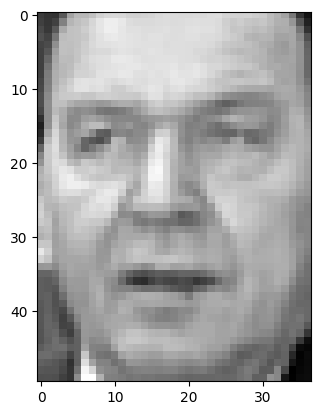

In [5]:
#Lectura base de datos
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
# datos tipo pandas
Xdata = pd.DataFrame(lfw_people.data)/255
y = lfw_people.target
print('Dimensiones tipo pandas: ',Xdata.shape)
print('Dimensiones tipo imágen:',lfw_people.images.shape)
plt.imshow(np.array(Xdata.iloc[300,:]).reshape(lfw_people.images.shape[1],
                                             lfw_people.images.shape[2]),cmap='gray')
plt.show()

In [6]:
#Particion entrenamiento y evaluación
# Tamaño Xtrain 70%, Tamaño Xtest 30%
Xtrain, Xtest, ytrain,ytest = train_test_split(Xdata,y,test_size=0.3, random_state=123)
Xtrain.head()

,0,1,2,3,4,5,6,7,8,9,...,1840,1841,1842,1843,1844,1845,1846,1847,1848,1849
510,0.000836,0.001143,0.001446,0.001666,0.001897,0.001994,0.002066,0.002071,0.002097,0.002138,...,0.000549,0.001384,0.002332,0.003189,0.003645,0.003727,0.003101,0.000856,0.000395,0.000466
1035,0.001589,0.001758,0.001922,0.002409,0.002819,0.002958,0.002917,0.002830,0.002830,0.002737,...,0.000297,0.000374,0.000384,0.000436,0.000359,0.000369,0.000420,0.000497,0.000466,0.000466
176,0.000892,0.001205,0.001210,0.001287,0.001492,0.001687,0.001763,0.001779,0.001845,0.001866,...,0.000451,0.000446,0.000482,0.000472,0.000477,0.000466,0.000513,0.000559,0.000600,0.000538
620,0.000267,0.000584,0.001446,0.002230,0.002507,0.002512,0.002491,0.002532,0.002584,0.002594,...,0.001333,0.001389,0.000723,0.000133,0.000190,0.000251,0.000313,0.000400,0.000549,0.000666
689,0.002261,0.002409,0.001958,0.001753,0.002127,0.002907,0.002932,0.002676,0.002655,0.002799,...,0.001569,0.001512,0.001548,0.001615,0.001794,0.002276,0.003106,0.003522,0.003573,0.003578


### 🔍 Entrenamiento y selección de modelos con GridSearchCV

Se definen tres modelos de clasificación usando `Pipeline`: regresión logística, SGD y SVM, todos con normalización previa usando `MinMaxScaler`.  
Para cada uno se realiza una búsqueda de hiperparámetros con `GridSearchCV`, utilizando validación cruzada de 5 folds y métrica de exactitud.

Cada modelo se entrena sobre los datos de entrenamiento y el mejor estimador es almacenado para su uso posterior. El conjunto de modelos resultantes se guarda con `joblib` en la carpeta `results`.


In [7]:

#%% Escoger modelo por gridsearchCV utilizando pipeline
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import joblib

#se crean listas de steps (pipelines)
steps=[[('nor', MinMaxScaler()),
        ('cla', LogisticRegression())], #Pipeline1
       [('nor',  MinMaxScaler()),
        ('cla', SGDClassifier())],#Pipeline2
        [('nor',MinMaxScaler()),
         ('cla', SVC())]#Pipeline3
      ]

parameters = [{
              'cla__C': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline1 - hyperparametros
              },
              {
              'cla__alpha': [1e-3,1e-2,1e-1,1,10,1e2,1e3],#Pipeline2 - hyperparametros
              },
              {
             'cla__C': [1,10,1e2,1e3,1e4],
             'cla__gamma': [1e-3, 1e-2, 1e-1,1, 10]    #Pipeline2 - hyperparametros
             }
             ]

label_models = ['MinMax_Logistic','MinMax_SGD', 'MinMax_SVCrbf']

models = []
filename = 'results/lfw_models'
for i in range(len(steps)): # recorrer modelos según lista pipeline
    print('modelo %d/%d' % (i+1,len(steps)))
    grid_search = GridSearchCV(Pipeline(steps[i]), parameters[i], n_jobs=-1,cv=5,
                                scoring='accuracy',refit= True,verbose=10)#gridsearch para modelo i
    grid_search.fit(Xtrain, ytrain)
    #mejor modelo entrenado
    models += [grid_search] #guardar modelos
    joblib.dump(models,filename+".pkl")

modelo 1/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 2/3
Fitting 5 folds for each of 7 candidates, totalling 35 fits
modelo 3/3
Fitting 5 folds for each of 25 candidates, totalling 125 fits


In [8]:
ind = models[2].cv_results_['mean_test_score'].argmax()#encontrar rendimiento más alto sobre CV del gridsearch en test
models[i].cv_results_['mean_test_score'][i]


np.float64(0.43286065070595453)

### 📊 Comparación de desempeño entre modelos

Se recorren los modelos entrenados para extraer el **mejor score promedio de validación** y su desviación estándar.  
Luego, se genera un gráfico de barras con barras de error para visualizar y comparar el rendimiento obtenido por cada modelo en el proceso de validación cruzada (`GridSearchCV`).

También se imprimen las etiquetas de los modelos y sus respectivos resultados redondeados.


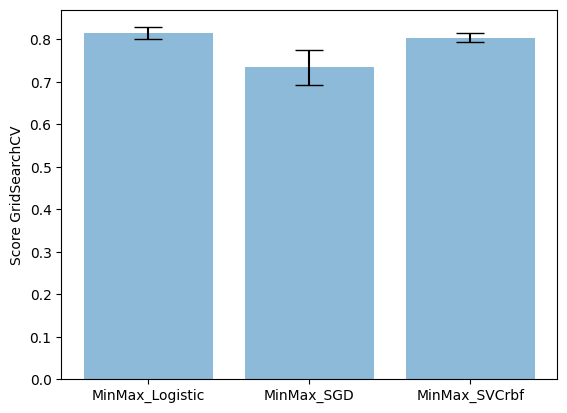

['MinMax_Logistic', 'MinMax_SGD', 'MinMax_SVCrbf']
[[0.815 0.734 0.804]
 [0.014 0.041 0.011]]


In [9]:
#recorrer modelos
bars_ = np.zeros((2,len(models)))#arreglo de barras para graficar mejores modelos en promedio con std
for i in range(len(models)):
  ind = models[i].cv_results_['mean_test_score'].argmax()#se determina el mejor score de clasificación
  bars_[0,i] = models[i].cv_results_['mean_test_score'][ind]#guardar score promedio del mejor modelo
  bars_[1,i] = models[i].cv_results_['std_test_score'][ind]#guardar std del mejor modelo

plt.bar(np.arange(len(models)), bars_[0], yerr=bars_[1], align='center', alpha=0.5, ecolor='black', capsize=10)
plt.ylabel('Score GridSearchCV')
plt.xticks(np.arange(len(models)))
plt.gca().set_xticklabels(label_models)
plt.show()

print(label_models)
print(np.round(bars_,3))

### ✅ Evaluación final de modelos sobre el conjunto de prueba

Se cargan los modelos entrenados previamente y se evalúan usando el conjunto de prueba (`Xtest`).  
Para cada modelo se calcula la **exactitud**, se genera la **matriz de confusión** y se imprime un reporte de clasificación con métricas por clase (precisión, recall, F1-score y soporte).

Esto permite analizar el rendimiento de cada modelo en un escenario real y observar cómo se comporta en la clasificación de rostros.


Evaluando modelo MinMax_Logistic (1/3)


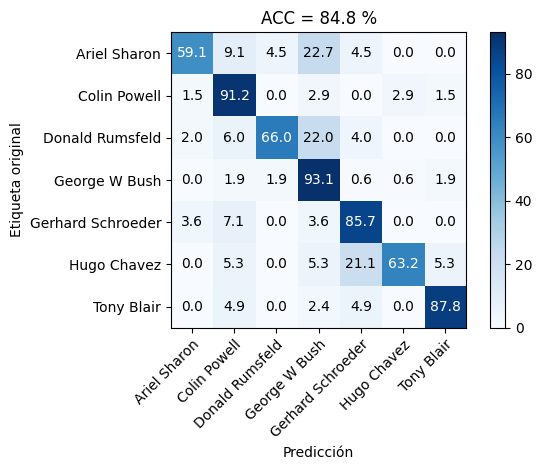

                   precision    recall  f1-score   support

     Ariel Sharon       0.81      0.59      0.68        22
     Colin Powell       0.83      0.91      0.87        68
  Donald Rumsfeld       0.89      0.66      0.76        50
    George W Bush       0.88      0.93      0.90       159
Gerhard Schroeder       0.71      0.86      0.77        28
      Hugo Chavez       0.80      0.63      0.71        19
       Tony Blair       0.88      0.88      0.88        41

         accuracy                           0.85       387
        macro avg       0.83      0.78      0.80       387
     weighted avg       0.85      0.85      0.84       387

Evaluando modelo MinMax_SGD (2/3)


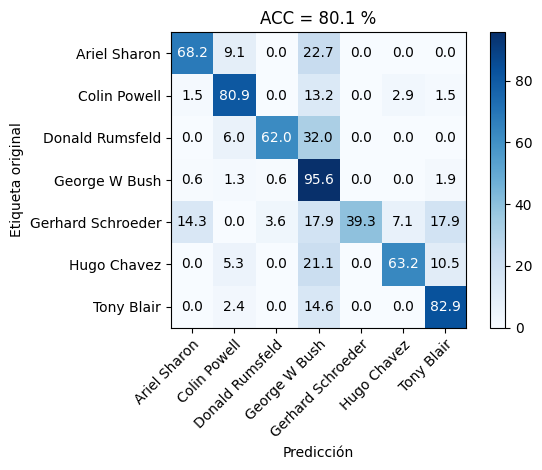

                   precision    recall  f1-score   support

     Ariel Sharon       0.71      0.68      0.70        22
     Colin Powell       0.86      0.81      0.83        68
  Donald Rumsfeld       0.94      0.62      0.75        50
    George W Bush       0.77      0.96      0.85       159
Gerhard Schroeder       1.00      0.39      0.56        28
      Hugo Chavez       0.75      0.63      0.69        19
       Tony Blair       0.76      0.83      0.79        41

         accuracy                           0.80       387
        macro avg       0.83      0.70      0.74       387
     weighted avg       0.82      0.80      0.79       387

Evaluando modelo MinMax_SVCrbf (3/3)


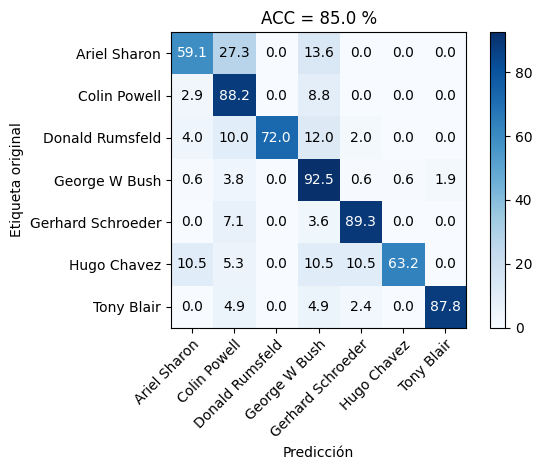

                   precision    recall  f1-score   support

     Ariel Sharon       0.65      0.59      0.62        22
     Colin Powell       0.73      0.88      0.80        68
  Donald Rumsfeld       1.00      0.72      0.84        50
    George W Bush       0.88      0.92      0.90       159
Gerhard Schroeder       0.83      0.89      0.86        28
      Hugo Chavez       0.92      0.63      0.75        19
       Tony Blair       0.92      0.88      0.90        41

         accuracy                           0.85       387
        macro avg       0.85      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387



In [ ]:
#%% evaluar sobre Xtest
my_model_loaded = joblib.load(filename+".pkl")
path_img = ''
for i in range(len(my_model_loaded)):
    print('Evaluando modelo %s (%d/%d)' % (label_models[i],i+1,len(my_model_loaded)))

    ytest_e = my_model_loaded[i].best_estimator_.predict(Xtest)
    acc = accuracy_score(ytest,ytest_e)

    plot_confusion_matrix(
                          ytest, ytest_e,
                          classes=lfw_people.target_names,
                          title='ACC = %.1f %%' % (100*acc)
                          )
    plt.autoscale()
    #save_fig(path_img,label_models[i])
    plt.show()

    cr = classification_report(
                               ytest, ytest_e,
                               labels=range(lfw_people.target_names.shape[0]),
                               target_names=lfw_people.target_names
                               )
    #support = #muestras en la clase estudiada
    print(cr)



# **Clasificadores Clasicos**

### 🔍 Entrenamiento, evaluación y curvas ROC de modelos con `GridSearchCV`

Este conjunto de funciones permite:

1. **Entrenar múltiples modelos** usando `Pipeline` y `GridSearchCV`, probando distintos hiperparámetros y escaladores.
2. **Evaluar el desempeño de cada modelo** sobre el conjunto de prueba, mostrando:
   - La exactitud (accuracy).
   - La **matriz de confusión** normalizada como mapa de calor.
   - Un reporte de clasificación detallado por clase.
3. **Graficar curvas ROC multicategoría**, calculando y visualizando:
   - Las curvas ROC individuales por clase.
   - Promedios `micro` y `macro` del AUC.

Estas herramientas ayudan a comparar modelos de clasificación multiclase de manera robusta y visual.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_curve, auc
)
from sklearn.preprocessing import MinMaxScaler, label_binarize
import joblib
import warnings

warnings.filterwarnings("ignore")

def entrenar_modelos(Xtrain, ytrain, steps, params, etiquetas_modelos, filename='modelos.pkl'):
    modelos = []
    for i in range(len(steps)):
        print(f'Entrenando modelo {etiquetas_modelos[i]} ({i+1}/{len(steps)})')
        pipe = Pipeline(steps[i])
        grid = GridSearchCV(pipe, params[i], cv=5, n_jobs=-1, scoring='accuracy', refit=True, verbose=1)
        grid.fit(Xtrain, ytrain)
        modelos.append(grid)
    joblib.dump(modelos, filename)
    return modelos


def evaluar_modelos(modelos, Xtest, ytest, etiquetas_modelos, target_names):
    for i, model in enumerate(modelos):
        print(f"\nEvaluando modelo: {etiquetas_modelos[i]}")
        best_model = model.best_estimator_
        ypred = best_model.predict(Xtest)
        acc = accuracy_score(ytest, ypred)
        print(f"Accuracy: {acc:.2%}")

        # Matriz de confusión
        cm = confusion_matrix(ytest, ypred, normalize='true')
        sns.heatmap(cm, annot=True, fmt=".1f", cmap="Blues",
                    xticklabels=target_names, yticklabels=target_names)
        plt.title(f"{etiquetas_modelos[i]} - Accuracy: {acc:.2%}")
        plt.xlabel("Predicción"); plt.ylabel("Real")
        plt.xticks(rotation=45); plt.tight_layout(); plt.show()

        # Reporte
        print(classification_report(ytest, ypred, target_names=target_names))


def graficar_roc_auc(modelos, Xtest, ytest, etiquetas_modelos, target_names):
    ytest_bin = label_binarize(ytest, classes=range(len(target_names)))

    for i, model in enumerate(modelos):
        print(f"\nCurva ROC para: {etiquetas_modelos[i]}")
        best_model = model.best_estimator_
        cla = best_model.named_steps['cla']

        # Obtener scores
        if hasattr(cla, 'decision_function'):
            scores = cla.decision_function(Xtest)
        elif hasattr(cla, 'predict_proba'):
            scores = cla.predict_proba(Xtest)
        else:
            print("Este modelo no permite ROC/AUC.")
            continue

        fpr, tpr, roc_auc = {}, {}, {}
        for j in range(ytest_bin.shape[1]):
            fpr[j], tpr[j], _ = roc_curve(ytest_bin[:, j], scores[:, j])
            roc_auc[j] = auc(fpr[j], tpr[j])

        # micro y macro
        fpr["micro"], tpr["micro"], _ = roc_curve(ytest_bin.ravel(), scores.ravel())
        roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

        all_fpr = np.unique(np.concatenate([fpr[j] for j in range(ytest_bin.shape[1])]))
        mean_tpr = np.zeros_like(all_fpr)
        for j in range(ytest_bin.shape[1]):
            mean_tpr += np.interp(all_fpr, fpr[j], tpr[j])
        mean_tpr /= ytest_bin.shape[1]
        fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
        roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

        # Gráfica
        plt.figure()
        plt.plot(fpr["micro"], tpr["micro"], linestyle=':', label=f'Micro-AUC = {roc_auc["micro"]:.2f}')
        plt.plot(fpr["macro"], tpr["macro"], linestyle='--', label=f'Macro-AUC = {roc_auc["macro"]:.2f}')
        for j in range(ytest_bin.shape[1]):
            plt.plot(fpr[j], tpr[j], label=f'{target_names[j]} AUC = {roc_auc[j]:.2f}')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.title(f"Curva ROC - {etiquetas_modelos[i]}")
        plt.xlabel("FPR"); plt.ylabel("TPR")
        plt.legend(); plt.grid(); plt.tight_layout()
        plt.show()



### ⚙️ Definición, entrenamiento y evaluación de clasificadores multiclase

En esta sección se definen y comparan tres modelos clásicos de clasificación:

- **Regresión Logística** (`LogisticRegression`)
- **Descenso de gradiente estocástico** con pérdida logística (`SGDClassifier`)
- **Clasificador Naive Bayes Gaussiano** (`GaussianNB`)

Cada modelo se integra en un pipeline junto a una normalización `MinMaxScaler`, y se entrena utilizando `GridSearchCV` para encontrar los mejores hiperparámetros (excepto en Naive Bayes, que no tiene hiperparámetros).

Posteriormente, se realiza:
- Una **evaluación general** del desempeño con matrices de confusión y métricas detalladas por clase.
- El cálculo y la **visualización de curvas ROC/AUC multiclase**, mostrando desempeño individual por clase y promedios macro/micro.

Este análisis permite identificar qué modelo se adapta mejor al problema de reconocimiento facial sobre el conjunto `LFW`.


Entrenando modelo LogisticRegression (1/3)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Entrenando modelo SGDClassifier (2/3)
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Entrenando modelo GaussianNB (3/3)
Fitting 5 folds for each of 1 candidates, totalling 5 fits

Evaluando modelo: LogisticRegression
Accuracy: 87.08%


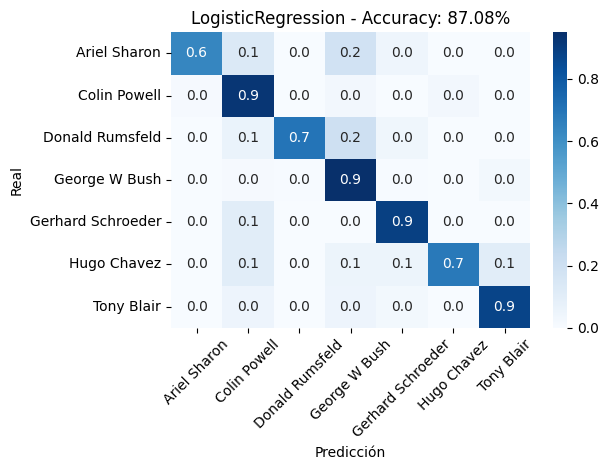

                   precision    recall  f1-score   support

     Ariel Sharon       0.93      0.64      0.76        22
     Colin Powell       0.81      0.93      0.86        68
  Donald Rumsfeld       0.97      0.70      0.81        50
    George W Bush       0.89      0.95      0.92       159
Gerhard Schroeder       0.81      0.89      0.85        28
      Hugo Chavez       0.87      0.68      0.76        19
       Tony Blair       0.86      0.88      0.87        41

         accuracy                           0.87       387
        macro avg       0.88      0.81      0.83       387
     weighted avg       0.88      0.87      0.87       387


Evaluando modelo: SGDClassifier
Accuracy: 83.72%


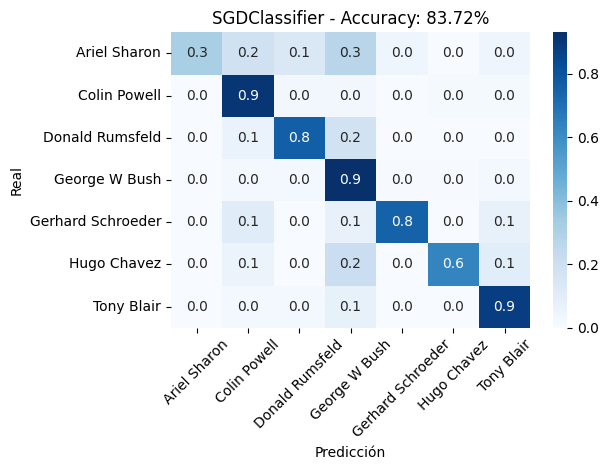

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.32      0.48        22
     Colin Powell       0.81      0.91      0.86        68
  Donald Rumsfeld       0.81      0.76      0.78        50
    George W Bush       0.85      0.93      0.89       159
Gerhard Schroeder       0.91      0.75      0.82        28
      Hugo Chavez       0.86      0.63      0.73        19
       Tony Blair       0.80      0.88      0.84        41

         accuracy                           0.84       387
        macro avg       0.86      0.74      0.77       387
     weighted avg       0.85      0.84      0.83       387


Evaluando modelo: GaussianNB
Accuracy: 40.31%


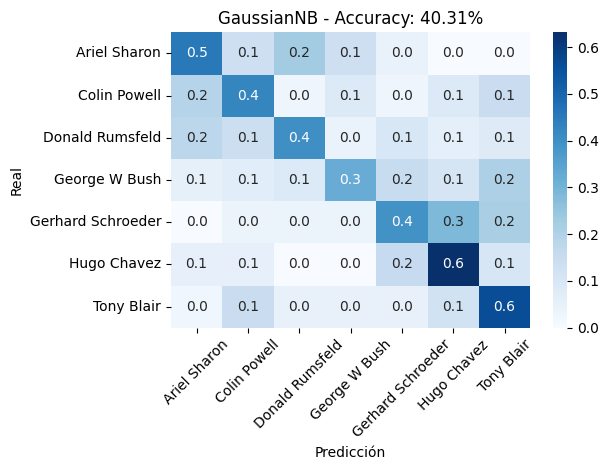

                   precision    recall  f1-score   support

     Ariel Sharon       0.23      0.45      0.31        22
     Colin Powell       0.50      0.43      0.46        68
  Donald Rumsfeld       0.45      0.40      0.43        50
    George W Bush       0.78      0.32      0.46       159
Gerhard Schroeder       0.23      0.39      0.29        28
      Hugo Chavez       0.24      0.63      0.34        19
       Tony Blair       0.29      0.56      0.39        41

         accuracy                           0.40       387
        macro avg       0.39      0.46      0.38       387
     weighted avg       0.54      0.40      0.42       387


Curva ROC para: LogisticRegression


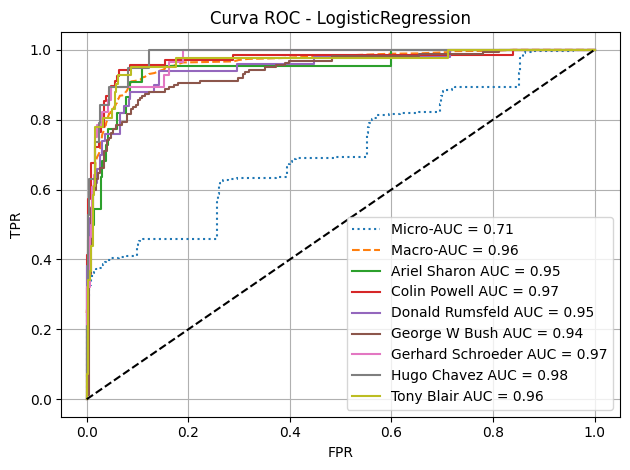


Curva ROC para: SGDClassifier


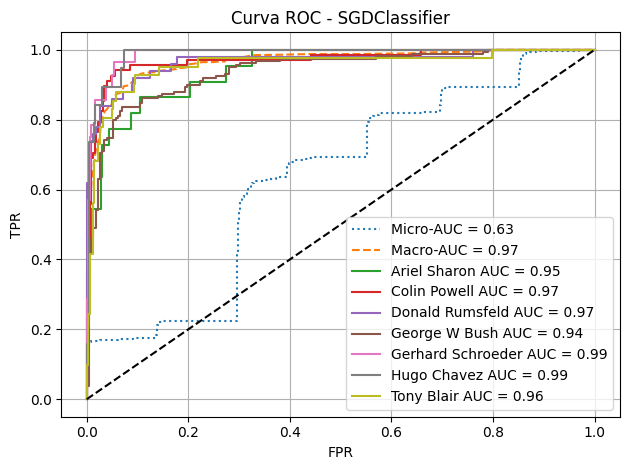


Curva ROC para: GaussianNB


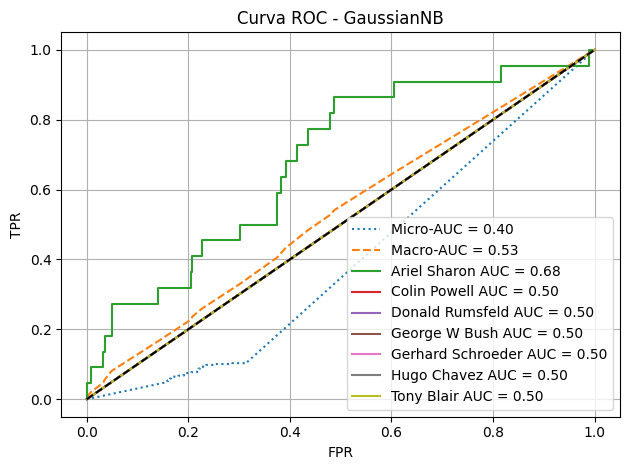

In [10]:
# === Definición de modelos ===
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB

steps = [
    [('nor', MinMaxScaler()), ('cla', LogisticRegression(max_iter=1000))],
    [('nor', MinMaxScaler()), ('cla', SGDClassifier(loss='log_loss', max_iter=1000))],
    [('nor', MinMaxScaler()), ('cla', GaussianNB())]
]

params = [
    {'cla__C': [1e-3, 1e-2, 1e-1, 1, 10]},
    {'cla__alpha': [1e-3, 1e-2, 1e-1, 1, 10]},
    {}  # sin hiperparámetros
]

label_models = ['LogisticRegression', 'SGDClassifier', 'GaussianNB']

# === Entrenamiento ===
modelos = entrenar_modelos(Xtrain, ytrain, steps, params, label_models, filename='results/modelos.pkl')

# === Evaluación general ===
evaluar_modelos(modelos, Xtest, ytest, label_models, lfw_people.target_names)

# === Curvas ROC/AUC ===
graficar_roc_auc(modelos, Xtest, ytest, label_models, lfw_people.target_names)


### 🧠 Evaluación de clasificadores adicionales (LDA, KNN, LinearSVC)

Se amplía el análisis incorporando tres nuevos modelos de clasificación:

- **Análisis Discriminante Lineal** (`LDA`)
- **K-Vecinos Más Cercanos** (`KNN`)
- **Máquinas de Vectores de Soporte Lineales** (`LinearSVC`)

Cada modelo se evalúa dentro de un pipeline con normalización `MinMaxScaler`. Se ajustan hiperparámetros relevantes mediante `GridSearchCV` y luego se evalúan en el conjunto de prueba.

Finalmente, se visualizan:
- **Matrices de confusión** para comparar el desempeño clase a clase.
- **Curvas ROC/AUC multiclase** para analizar la capacidad de discriminación global y por clase.

Este bloque permite comparar estos modelos frente a los anteriores (Logistic, SGD, Naive Bayes) en tareas de reconocimiento facial multiclase.


Entrenando modelo LDA (1/3)
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Entrenando modelo KNN (2/3)
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Entrenando modelo LinearSVC (3/3)
Fitting 5 folds for each of 4 candidates, totalling 20 fits

Evaluando modelo: LDA
Accuracy: 70.03%


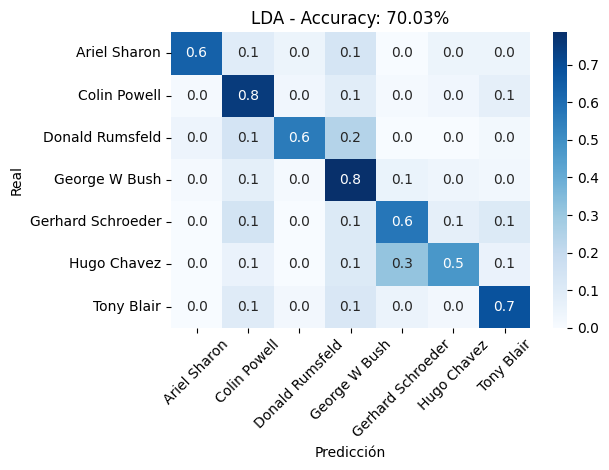

                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.64      0.68        22
     Colin Powell       0.63      0.75      0.68        68
  Donald Rumsfeld       0.82      0.56      0.67        50
    George W Bush       0.80      0.79      0.79       159
Gerhard Schroeder       0.48      0.57      0.52        28
      Hugo Chavez       0.43      0.47      0.45        19
       Tony Blair       0.65      0.68      0.67        41

         accuracy                           0.70       387
        macro avg       0.65      0.64      0.64       387
     weighted avg       0.71      0.70      0.70       387


Evaluando modelo: KNN
Accuracy: 59.43%


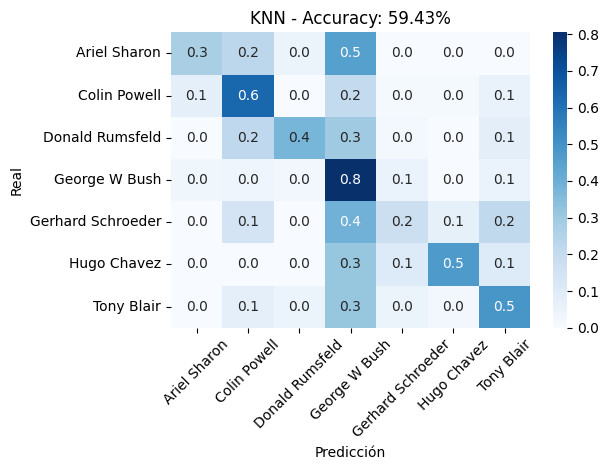

                   precision    recall  f1-score   support

     Ariel Sharon       0.38      0.27      0.32        22
     Colin Powell       0.60      0.63      0.61        68
  Donald Rumsfeld       0.73      0.38      0.50        50
    George W Bush       0.65      0.81      0.72       159
Gerhard Schroeder       0.26      0.18      0.21        28
      Hugo Chavez       0.69      0.47      0.56        19
       Tony Blair       0.45      0.49      0.47        41

         accuracy                           0.59       387
        macro avg       0.54      0.46      0.49       387
     weighted avg       0.59      0.59      0.58       387


Evaluando modelo: LinearSVC
Accuracy: 86.30%


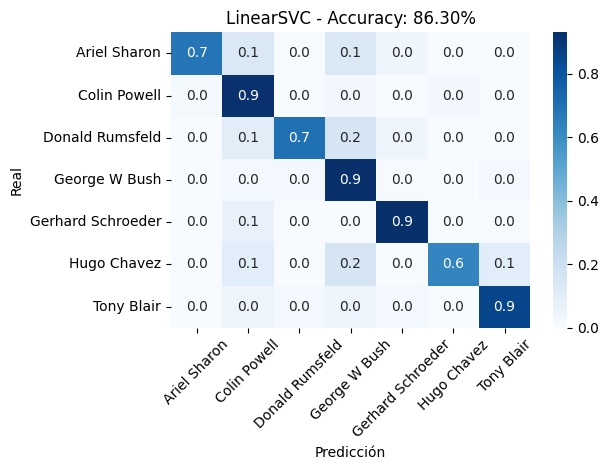

                   precision    recall  f1-score   support

     Ariel Sharon       0.94      0.68      0.79        22
     Colin Powell       0.78      0.93      0.85        68
  Donald Rumsfeld       0.90      0.70      0.79        50
    George W Bush       0.89      0.93      0.91       159
Gerhard Schroeder       0.84      0.93      0.88        28
      Hugo Chavez       0.86      0.63      0.73        19
       Tony Blair       0.88      0.85      0.86        41

         accuracy                           0.86       387
        macro avg       0.87      0.81      0.83       387
     weighted avg       0.87      0.86      0.86       387


Curva ROC para: LDA


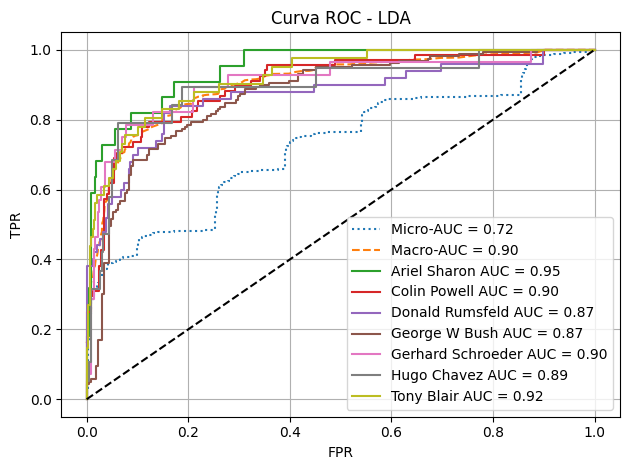


Curva ROC para: KNN


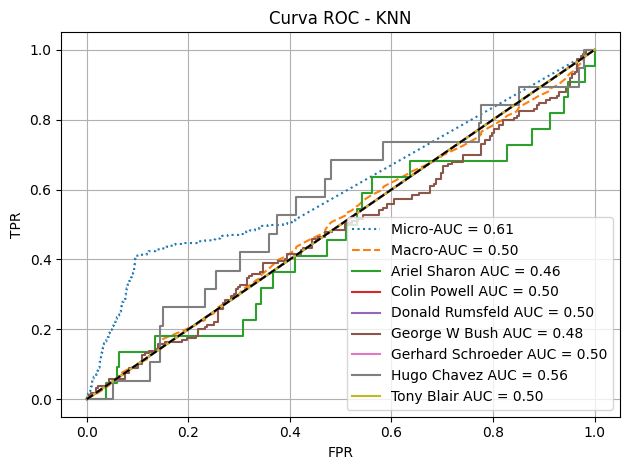


Curva ROC para: LinearSVC


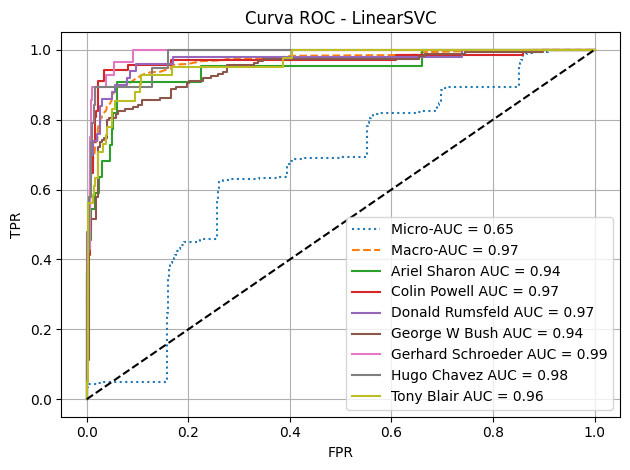

In [ ]:
# Reimportar lo necesario para que todo esté definido en este entorno
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import MinMaxScaler, label_binarize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

# Redefinir los pipelines y los parámetros para los nuevos modelos
steps_new = [
    [('nor', MinMaxScaler()), ('cla', LinearDiscriminantAnalysis())],
    [('nor', MinMaxScaler()), ('cla', KNeighborsClassifier())],
    [('nor', MinMaxScaler()), ('cla', LinearSVC(max_iter=10000))]
]

params_new = [
    {'cla__solver': ['svd', 'lsqr']},  # LDA
    {'cla__n_neighbors': [3, 5, 7], 'cla__weights': ['uniform', 'distance']},  # KNN
    {'cla__C': [0.01, 0.1, 1, 10]}  # LinearSVC
]

label_models_new = ['LDA', 'KNN', 'LinearSVC']

steps_new, params_new, label_models_new


modelos_new = entrenar_modelos(Xtrain, ytrain, steps_new, params_new, label_models_new, filename='results/modelos_nuevos.pkl')

evaluar_modelos(modelos_new, Xtest, ytest, label_models_new, lfw_people.target_names)

graficar_roc_auc(modelos_new, Xtest, ytest, label_models_new, lfw_people.target_names)



### 🌲🌀 Evaluación de SVC y RandomForest

Este bloque añade dos clasificadores ampliamente usados:

- **SVC**: basado en Máquinas de Vectores de Soporte con núcleos no lineales (`rbf`, `poly`), capaz de captar patrones complejos.
- **Random Forest**: ensamble de árboles de decisión que mejora la generalización al reducir el sobreajuste.

Se optimizan hiperparámetros clave como `C`, `gamma`, `kernel` para SVC, y `n_estimators`, `max_depth` para Random Forest. Los modelos se integran a un pipeline con normalización y se evalúan tanto por accuracy como por curvas ROC multiclase.

Este análisis permite contrastar modelos lineales, no lineales y de tipo ensamble en la tarea de reconocimiento facial multiclase.


In [11]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# === Pipelines ===
steps_extra = [
    [('nor', MinMaxScaler()), ('cla', SVC(probability=True))],
    [('nor', MinMaxScaler()), ('cla', RandomForestClassifier(random_state=42))]
]

# === Hiperparámetros ===
params_extra = [
    {
        'cla__C': [0.1, 1, 10],
        'cla__kernel': ['rbf', 'poly'],
        'cla__gamma': ['scale', 'auto']
    },
    {
        'cla__n_estimators': [50, 100],
        'cla__max_depth': [None, 10, 20],
        'cla__min_samples_split': [2, 5]
    }
]

# === Etiquetas de los modelos ===
label_models_extra = ['SVC', 'RandomForest']


In [12]:
# Entrenamiento
modelos_extra = entrenar_modelos(Xtrain, ytrain, steps_extra, params_extra, label_models_extra, filename='results/modelos_extra.pkl')


Entrenando modelo SVC (1/2)
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Entrenando modelo RandomForest (2/2)
Fitting 5 folds for each of 12 candidates, totalling 60 fits



Evaluando modelo: SVC
Accuracy: 85.27%


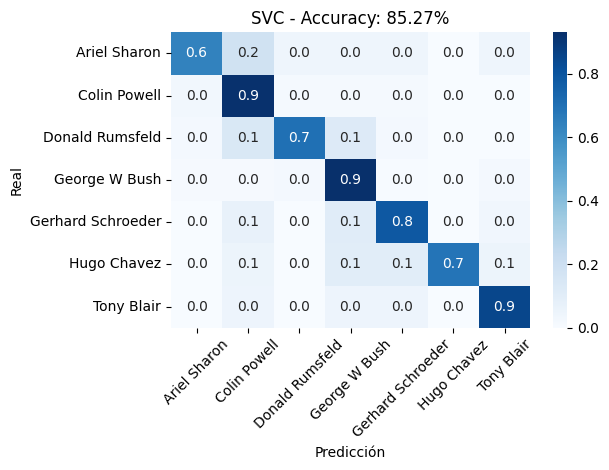

                   precision    recall  f1-score   support

     Ariel Sharon       0.74      0.64      0.68        22
     Colin Powell       0.78      0.93      0.85        68
  Donald Rumsfeld       0.88      0.70      0.78        50
    George W Bush       0.91      0.93      0.92       159
Gerhard Schroeder       0.73      0.79      0.76        28
      Hugo Chavez       1.00      0.68      0.81        19
       Tony Blair       0.85      0.85      0.85        41

         accuracy                           0.85       387
        macro avg       0.84      0.79      0.81       387
     weighted avg       0.86      0.85      0.85       387


Evaluando modelo: RandomForest
Accuracy: 62.02%


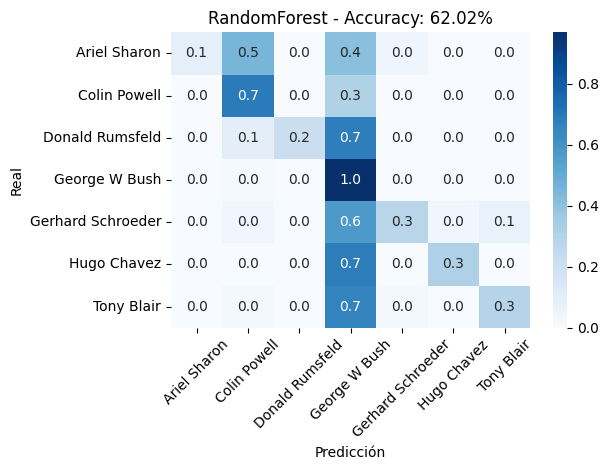

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      0.09      0.17        22
     Colin Powell       0.70      0.69      0.70        68
  Donald Rumsfeld       1.00      0.22      0.36        50
    George W Bush       0.56      0.97      0.71       159
Gerhard Schroeder       0.73      0.29      0.41        28
      Hugo Chavez       0.75      0.32      0.44        19
       Tony Blair       0.86      0.29      0.44        41

         accuracy                           0.62       387
        macro avg       0.80      0.41      0.46       387
     weighted avg       0.72      0.62      0.57       387



In [13]:
# Evaluación
evaluar_modelos(modelos_extra, Xtest, ytest, label_models_extra, lfw_people.target_names)



Curva ROC para: SVC


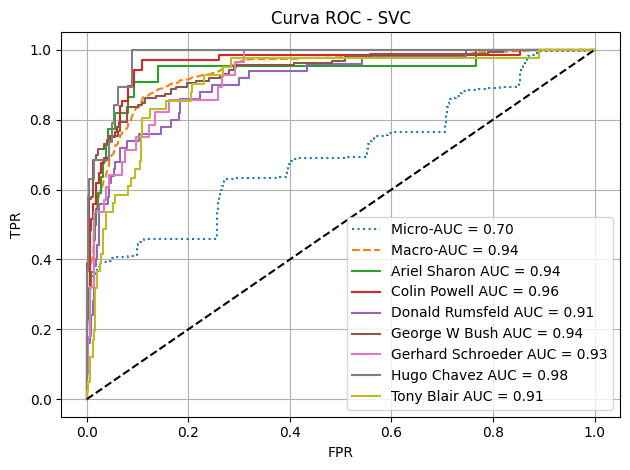


Curva ROC para: RandomForest


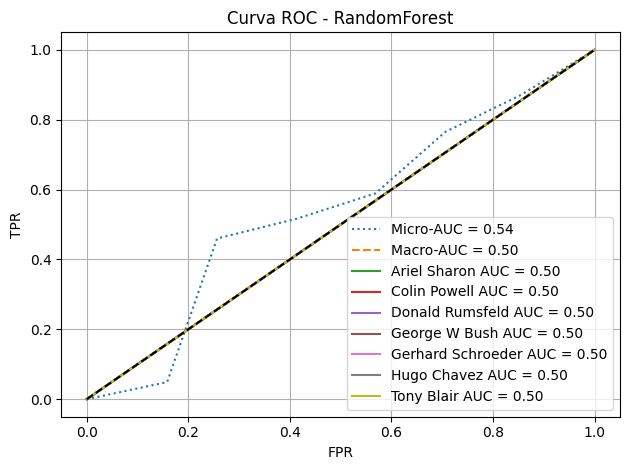

In [14]:
# Curvas ROC/AUC
graficar_roc_auc(modelos_extra, Xtest, ytest, label_models_extra, lfw_people.target_names)

